## Part-of-speech Tagging using BiLSTM

In [1]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 토큰화에 품사 태깅이 된 데이터 받아오기
tagged_sentences = nltk.corpus.treebank.tagged_sents()
print(len(tagged_sentences))

3914


In [2]:
tagged_sentences[1]

[('Mr.', 'NNP'),
 ('Vinken', 'NNP'),
 ('is', 'VBZ'),
 ('chairman', 'NN'),
 ('of', 'IN'),
 ('Elsevier', 'NNP'),
 ('N.V.', 'NNP'),
 (',', ','),
 ('the', 'DT'),
 ('Dutch', 'NNP'),
 ('publishing', 'VBG'),
 ('group', 'NN'),
 ('.', '.')]

In [3]:
sentences, pos_tags = [], []
for tagged_sentence in tagged_sentences:
    sentence, tag_info = zip(*tagged_sentence)
    sentences.append(list(sentence))
    pos_tags.append(list(tag_info))

print(sentences[0])
print(pos_tags[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


max length :  271
average length :  25.722023505365357


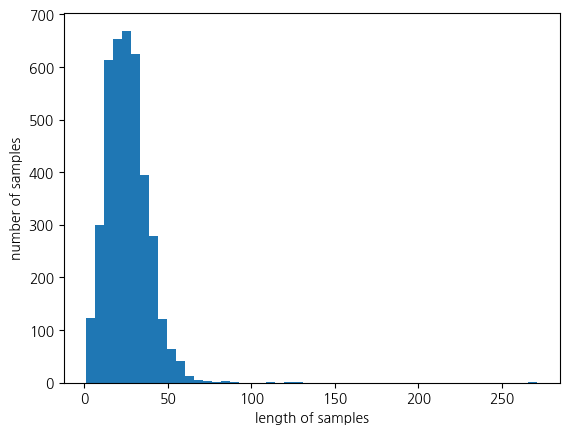

In [7]:
print('max length : ', max(len(l) for l in sentences))
print('average length : ', (sum(map(len, sentences)) / len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [8]:
def tokenize(samples):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(samples)
    return tokenizer

src_tokenizer = tokenize(sentences)
tar_tokenizer = tokenize(pos_tags)

vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1

print(vocab_size)
print(tag_size)

11388
47


In [9]:
x_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)

print(x_train[:2])
print(y_train[:2])

[[5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3], [31, 3746, 20, 177, 4, 5602, 2915, 1, 2, 2916, 637, 147, 3]]
[[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9], [3, 3, 17, 1, 2, 3, 3, 8, 4, 3, 19, 1, 9]]


In [10]:
maxlen = 150
x_train = pad_sequences(x_train, maxlen=maxlen, padding='post')
y_train = pad_sequences(y_train, maxlen=maxlen, padding='post')

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3131, 150)
(3131, 150)
(783, 150)
(783, 150)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
# 각 time step마다 loss를 계산해서 가중치를 업데이트하라는 의미이다.
# many to many로 동작할 수 있게 해주는 부분임
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, epochs=7, validation_data=(x_test, y_test))

Epoch 1/7
25/25 [==============================] - 9s 108ms/step - loss: 0.5895 - accuracy: 0.1347 - val_loss: 0.5291 - val_accuracy: 0.1303
Epoch 2/7
25/25 [==============================] - 1s 25ms/step - loss: 0.4993 - accuracy: 0.1860 - val_loss: 0.4910 - val_accuracy: 0.2794
Epoch 3/7
25/25 [==============================] - 0s 18ms/step - loss: 0.4496 - accuracy: 0.3579 - val_loss: 0.4108 - val_accuracy: 0.4550
Epoch 4/7
25/25 [==============================] - 0s 19ms/step - loss: 0.3406 - accuracy: 0.5074 - val_loss: 0.2818 - val_accuracy: 0.5868
Epoch 5/7
25/25 [==============================] - 0s 19ms/step - loss: 0.2222 - accuracy: 0.6890 - val_loss: 0.1789 - val_accuracy: 0.7687
Epoch 6/7
25/25 [==============================] - 0s 18ms/step - loss: 0.1313 - accuracy: 0.8435 - val_loss: 0.1104 - val_accuracy: 0.8623
Epoch 7/7
25/25 [==============================] - 0s 18ms/step - loss: 0.0756 - accuracy: 0.9132 - val_loss: 0.0765 - val_accuracy: 0.8958


In [12]:
model.evaluate(x_test, y_test)

25/25 [==============================] - 0s 17ms/step - loss: 0.0829 - accuracy: 0.8849


[0.08285515755414963, 0.8849092125892639]

In [13]:
index_to_word = src_tokenizer.index_word
index_to_tag = tar_tokenizer.index_word

i = 10
y_predicted = model.predict(np.array([x_test[i]]))
y_predicted = np.argmax(y_predicted, axis=-1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(x_test[i], y_test[i], y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_tag[tag].upper(), index_to_tag[pred].upper()))

1/1 [==============================] - 2s 2s/step
단어             |실제값  |예측값
-----------------------------------
since            : IN      IN
chalk            : NN      NNP
first            : RB      JJ
touched          : VBD     JJ
slate            : NN      NNP
,                : ,       ,
schoolchildren   : NN      NNP
have             : VBP     VBP
wanted           : VBN     VBD
*-1              : -NONE-  -NONE-
to               : TO      TO
know             : VB      VB
:                : :       :
what             : WP      WP
's               : VBZ     POS
*t*-2            : -NONE-  -NONE-
on               : IN      IN
the              : DT      DT
test             : NN      NN
?                : .       .


## Named Entity Recognition

In [21]:
from nltk import word_tokenize, pos_tag, ne_chunk

sentence = 'James is working at Disney in London'
sentence2 = 'james is working at disney in london'
tokenized_sentence = pos_tag(word_tokenize(sentence))
tokenized_sentence2 = pos_tag(word_tokenize(sentence2))

print(tokenized_sentence)
print(tokenized_sentence2)

[('James', 'NNP'), ('is', 'VBZ'), ('working', 'VBG'), ('at', 'IN'), ('Disney', 'NNP'), ('in', 'IN'), ('London', 'NNP')]
[('james', 'NNS'), ('is', 'VBZ'), ('working', 'VBG'), ('at', 'IN'), ('disney', 'NN'), ('in', 'IN'), ('london', 'NN')]


In [20]:
# 개체명 인식
ner_sentence = ne_chunk(tokenized_sentence)
print(ner_sentence)

(S
  (PERSON James/NNP)
  is/VBZ
  working/VBG
  at/IN
  (ORGANIZATION Disney/NNP)
  in/IN
  (GPE London/NNP))


In [23]:
ner_sentence2 = ne_chunk(tokenized_sentence2)
print(ner_sentence2)

(S james/NNS is/VBZ working/VBG at/IN disney/NN in/IN london/NN)


In [25]:
import re
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/12.%20RNN%20Sequence%20Labeling/dataset/train.txt", filename="train.txt")

f = open('train.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0] == '\n':
        if len(sentence) >0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    
    splits = line.split()
    splits[-1] = re.sub(r'\n', '', splits[-1])
    word = splits[0].lower()
    sentence.append([word, splits[-1]])

In [26]:
print(len(tagged_sentences))

14041


In [27]:
tagged_sentences[0]

[['eu', 'B-ORG'],
 ['rejects', 'O'],
 ['german', 'B-MISC'],
 ['call', 'O'],
 ['to', 'O'],
 ['boycott', 'O'],
 ['british', 'B-MISC'],
 ['lamb', 'O'],
 ['.', 'O']]

In [28]:
sentences, ner_tags = [], []
for tagged_sentence in tagged_sentences:
    sentence, tag_info = zip(*tagged_sentence)
    sentences.append(list(sentence))
    ner_tags.append(list(tag_info))

In [29]:
print(sentences[0])
print(ner_tags[0])

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


샘플의 최대 길이 : 113
샘플의 평균 길이 : 14.501887


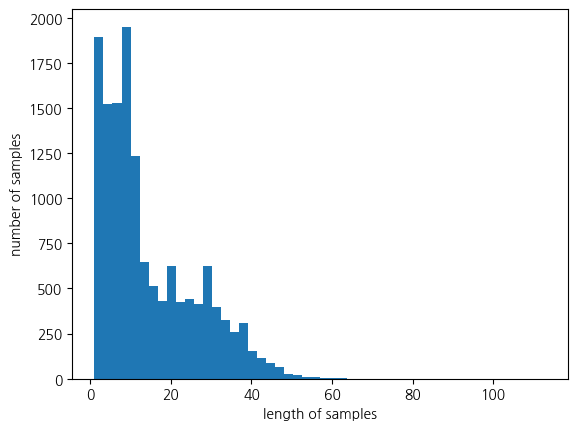

In [30]:
print('샘플의 최대 길이 : %d' % max(len(sentence) for sentence in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(sentence) for sentence in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [31]:
src_tokenizer = Tokenizer(oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

In [32]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print(vocab_size)
print(tag_size)

21011
10


In [33]:
x_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

print(x_train[0])
print(y_train[0])

[989, 10951, 205, 629, 7, 3939, 216, 5774, 3]
[4, 1, 7, 1, 1, 1, 7, 1, 1]


In [34]:
max_len = 70
x_train = pad_sequences(x_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, epochs=8, validation_data=(x_test, y_test))

Epoch 1/8
88/88 [==============================] - 9s 38ms/step - loss: 0.1957 - accuracy: 0.8230 - val_loss: 0.1210 - val_accuracy: 0.8379
Epoch 2/8
88/88 [==============================] - 1s 16ms/step - loss: 0.0969 - accuracy: 0.8507 - val_loss: 0.0817 - val_accuracy: 0.8814
Epoch 3/8
88/88 [==============================] - 1s 15ms/step - loss: 0.0629 - accuracy: 0.9071 - val_loss: 0.0609 - val_accuracy: 0.9158
Epoch 4/8
88/88 [==============================] - 1s 15ms/step - loss: 0.0388 - accuracy: 0.9475 - val_loss: 0.0450 - val_accuracy: 0.9453
Epoch 5/8
88/88 [==============================] - 1s 15ms/step - loss: 0.0229 - accuracy: 0.9705 - val_loss: 0.0375 - val_accuracy: 0.9535
Epoch 6/8
88/88 [==============================] - 1s 15ms/step - loss: 0.0149 - accuracy: 0.9805 - val_loss: 0.0348 - val_accuracy: 0.9577
Epoch 7/8
88/88 [==============================] - 1s 15ms/step - loss: 0.0105 - accuracy: 0.9863 - val_loss: 0.0341 - val_accuracy: 0.9602
Epoch 8/8
88/88 [===

In [36]:
model.evaluate(x_test, y_test)

88/88 [==============================] - 1s 7ms/step - loss: 0.0348 - accuracy: 0.9587


[0.03483003377914429, 0.9587371349334717]

In [37]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

i = 10

y_predicted = model.predict(np.array([x_test[i]]))

y_predicted = np.argmax(y_predicted, axis=-1)

labels = np.argmax(y_test[i], -1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(x_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag].upper(), index_to_ner[pred].upper()))

1/1 [==============================] - 2s 2s/step
단어             |실제값  |예측값
-----------------------------------
els              : B-PER   B-PER
callens          : I-PER   I-PER
(                : O       O
belgium          : B-LOC   B-LOC
)                : O       O
beat             : O       O
annabel          : B-PER   B-PER
ellwood          : I-PER   I-PER
(                : O       O
australia        : B-LOC   B-LOC
)                : O       O
6-4              : O       O


## Named Entity Recognition using BiLSTM

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

data = pd.read_csv('C:/Users/Myeong/dding/data/ner_dataset.csv', encoding='latin1')

data[:5]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [4]:
data.isnull().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [5]:
print(data['Sentence #'].nunique())
print(data.Word.nunique())
print(data.Tag.nunique())

47959
35178
17


In [7]:
print('Tag 열의 각각의 값 개수 카운트')
print('====================')
print(data.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각각의 값 개수 카운트
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


In [8]:
data = data.fillna(method='ffill') # Null값을 가진 행의 바로 앞의 행의 값으로 Null값을 채움
print(data.tail())

              Sentence #       Word  POS Tag
1048570  Sentence: 47959       they  PRP   O
1048571  Sentence: 47959  responded  VBD   O
1048572  Sentence: 47959         to   TO   O
1048573  Sentence: 47959        the   DT   O
1048574  Sentence: 47959     attack   NN   O


In [9]:
data.isnull().sum()

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

In [10]:
data['Word'] = data['Word'].str.lower()
print(data.Word.nunique())

31817


In [11]:
func = lambda temp: [(w,t) for w,t in zip(temp['Word'].values.tolist(), temp['Tag'].values.tolist())]
tagged_sentences = [t for t in data.groupby('Sentence #').apply(func)]
print(len(tagged_sentences))

47959


In [12]:
print(tagged_sentences[1])

[('iranian', 'B-gpe'), ('officials', 'O'), ('say', 'O'), ('they', 'O'), ('expect', 'O'), ('to', 'O'), ('get', 'O'), ('access', 'O'), ('to', 'O'), ('sealed', 'O'), ('sensitive', 'O'), ('parts', 'O'), ('of', 'O'), ('the', 'O'), ('plant', 'O'), ('wednesday', 'B-tim'), (',', 'O'), ('after', 'O'), ('an', 'O'), ('iaea', 'B-org'), ('surveillance', 'O'), ('system', 'O'), ('begins', 'O'), ('functioning', 'O'), ('.', 'O')]


In [16]:
sentences, ner_tags = [],[]
for tagged_sentence in tagged_sentences:

    sentence, tag_info = zip(*tagged_sentence)
    sentences.append(list(sentence))
    ner_tags.append(list(tag_info))

In [18]:
print(sentences[0])
print(ner_tags[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.863988


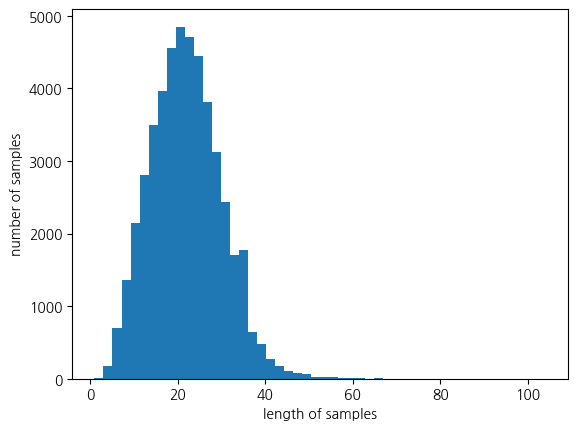

In [19]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
src_tokenizer = Tokenizer(oov_token='OOV')
tar_tokenizer = Tokenizer(lower=False)

src_tokenizer.fit_on_texts(sentences)
tar_tokenizer.fit_on_texts(ner_tags)

vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1

print(vocab_size)
print(tag_size)

31819
18


In [22]:
x_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat', 0: 'PAD'}


In [23]:
maxlen = 70
x_data = pad_sequences(x_data, maxlen=maxlen)
y_data = pad_sequences(y_data, maxlen=maxlen)

x_train, x_test, y_train_int, y_test_int = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

y_train = to_categorical(y_train_int, num_classes=tag_size)
y_test = to_categorical(y_test_int, num_classes=tag_size)

print('훈련 샘플 문장의 크기 : {}'.format(x_train.shape))
print('훈련 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_train_int.shape))
print('훈련 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(x_test.shape))
print('테스트 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_test_int.shape))
print('테스트 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블(정수 인코딩)의 크기 : (38367, 70)
훈련 샘플 레이블(원-핫 인코딩)의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블(정수 인코딩)의 크기 : (9592, 70)
테스트 샘플 레이블(원-핫 인코딩)의 크기 : (9592, 70, 18)


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=128, epochs=6, validation_split=0.1)

Epoch 1/6
270/270 [==============================] - 122s 429ms/step - loss: 0.1752 - accuracy: 0.8745 - val_loss: 0.0818 - val_accuracy: 0.9306
Epoch 2/6
270/270 [==============================] - 114s 422ms/step - loss: 0.0544 - accuracy: 0.9500 - val_loss: 0.0492 - val_accuracy: 0.9544
Epoch 3/6
270/270 [==============================] - 113s 417ms/step - loss: 0.0366 - accuracy: 0.9646 - val_loss: 0.0445 - val_accuracy: 0.9579
Epoch 4/6
270/270 [==============================] - 113s 418ms/step - loss: 0.0299 - accuracy: 0.9702 - val_loss: 0.0447 - val_accuracy: 0.9580
Epoch 5/6
270/270 [==============================] - 113s 419ms/step - loss: 0.0258 - accuracy: 0.9737 - val_loss: 0.0456 - val_accuracy: 0.9571
Epoch 6/6
270/270 [==============================] - 113s 417ms/step - loss: 0.0226 - accuracy: 0.9767 - val_loss: 0.0470 - val_accuracy: 0.9563


In [28]:
from seqeval.metrics import f1_score, classification_report

def sequences_to_tag(sequences):
    result = []

    for sequence in sequences:
        word_sequence=[]
        for pred in sequence:
            pred_index = np.argmax(pred)
            word_sequence.append(index_to_ner[pred_index].replace("PAD", "O"))
        result.append(word_sequence)
    return result
y_predicted = model.predict([x_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

print("f1_score : {:.1f}".format(f1_score(test_tags, pred_tags)))
print(classification_report(test_tags, pred_tags))

300/300 [==============================] - 15s 50ms/step
f1_score : 0.8
              precision    recall  f1-score   support

         art       0.33      0.02      0.04        94
         eve       0.31      0.24      0.27        70
         geo       0.83      0.85      0.84      7558
         gpe       0.96      0.94      0.95      3142
         nat       0.56      0.12      0.20        40
         org       0.55      0.61      0.58      4151
         per       0.72      0.68      0.70      3400
         tim       0.83      0.85      0.84      4077

   micro avg       0.78      0.79      0.78     22532
   macro avg       0.64      0.54      0.55     22532
weighted avg       0.78      0.79      0.78     22532



In [32]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional, TimeDistributed, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_crf import CRFModel
from seqeval.metrics import f1_score, classification_report

embedding_dim = 128
hidden_units = 64
dropout = 0.3

sequence_input = Input(shape=(maxlen,), dtype=tf.int32, name='sequence_input')
model_embedding = Embedding(input_dim = vocab_size,
                            output_dim = embedding_dim,
                            input_length = maxlen)(sequence_input)
model_bilstm = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(model_embedding)
model_dropout = TimeDistributed(Dropout(dropout))(model_bilstm)
model_dense = TimeDistributed(Dense(tag_size, activation='relu'))(model_dropout)

base = Model(inputs=sequence_input, outputs=model_dense)
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
history=model.fit(x_train, y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[es])

Epoch 1/15
270/270 [==============================] - 49s 164ms/step - decode_sequence_accuracy: 0.9200 - loss: 30.0504 - val_decode_sequence_accuracy: 0.9596 - val_loss: 8.7825
Epoch 2/15
270/270 [==============================] - 43s 158ms/step - decode_sequence_accuracy: 0.9675 - loss: 7.0701 - val_decode_sequence_accuracy: 0.9781 - val_loss: 4.6508
Epoch 3/15
270/270 [==============================] - 43s 160ms/step - decode_sequence_accuracy: 0.9829 - loss: 3.6736 - val_decode_sequence_accuracy: 0.9835 - val_loss: 3.1719
Epoch 4/15
270/270 [==============================] - 42s 157ms/step - decode_sequence_accuracy: 0.9868 - loss: 2.5847 - val_decode_sequence_accuracy: 0.9843 - val_loss: 2.8562
Epoch 5/15
270/270 [==============================] - 43s 158ms/step - decode_sequence_accuracy: 0.9884 - loss: 2.1068 - val_decode_sequence_accuracy: 0.9848 - val_loss: 2.6889
Epoch 6/15
270/270 [==============================] - 44s 164ms/step - decode_sequence_accuracy: 0.9896 - loss: 1.

In [34]:

i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([x_test[i]]))[0] # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
labels = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(x_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

1/1 [==============================] - 1s 763ms/step
단어             |실제값  |예측값
-----------------------------------
carlsen          : B-per   B-per
will             : O       O
face             : O       O
another          : O       O
thai             : B-gpe   B-gpe
opponent         : O       O
,                : O       O
43rd-ranked      : O       O
paradorn         : B-per   B-per
srichaphan       : I-per   I-per
,                : O       O
in               : O       O
the              : O       O
second           : O       O
round            : O       O
.                : O       O


In [40]:
y_predicted = model.predict(x_test)[0]

300/300 [==============================] - 17s 57ms/step


In [41]:
y_predicted[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 6, 5, 1, 4, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [42]:
def sequences_to_tag_for_crf(sequences): 
    result = []
    # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
    for sequence in sequences: 
        word_sequence = []
        # 시퀀스로부터 예측 정수 레이블을 하나씩 꺼낸다.
        for pred_index in sequence:
            # index_to_ner을 사용하여 정수를 태깅 정보로 변환. 'PAD'는 'O'로 변경.
            word_sequence.append(index_to_ner[pred_index].replace("PAD", "O"))
        result.append(word_sequence)
    return result

pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))
print(classification_report(test_tags, pred_tags))

F1-score: 79.4%
              precision    recall  f1-score   support

         art       0.00      0.00      0.00        94
         eve       0.52      0.21      0.30        70
         geo       0.82      0.85      0.84      7558
         gpe       0.95      0.94      0.94      3142
         nat       0.75      0.07      0.14        40
         org       0.68      0.54      0.60      4151
         per       0.72      0.74      0.73      3400
         tim       0.88      0.82      0.85      4077

   micro avg       0.81      0.78      0.79     22532
   macro avg       0.67      0.52      0.55     22532
weighted avg       0.81      0.78      0.79     22532

